In [262]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade
# install joblib. This will be used to save your model. 
# Restart your kernel after installing
!pip install joblib

This model uses a neural network and GridSearchCV to predict share price impacts of Interest changes

# Read the CSV and Perform Basic Data Cleaning

In [263]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [264]:
df_stock1 = pd.read_csv("../../static/data/shl.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
6003,22/07/2022,34.500000,34.970001,34.380001,34.750000,34.750000,1301058.0,1.35,1.75,125.0
6004,25/07/2022,34.990002,34.990002,34.130001,34.450001,34.450001,720778.0,1.35,1.75,125.0
6005,26/07/2022,34.520000,34.680000,33.950001,33.950001,33.950001,726919.0,1.35,1.75,125.0
6006,27/07/2022,33.980000,34.110001,33.540001,33.750000,33.750000,932062.0,1.35,2.50,125.0
6007,28/07/2022,33.520000,33.724998,33.020000,33.540001,33.540001,553468.0,1.35,2.50,125.0


In [265]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

df_mongo = pd.DataFrame(list(db.shl.find()))
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
# print(last_val)
print(last_date,last_close)
df_mongo.tail


29/07/2022 34.27000045776367


<bound method NDFrame.tail of                            _id        Date       Open       High        Low  \
0     62e39c1f024ecb686e958085   4/01/1999   2.610000   2.610000   2.500000   
1     62e39c1f024ecb686e958086   5/01/1999   2.460000   2.600000   2.460000   
2     62e39c1f024ecb686e958087   6/01/1999   2.600000   2.600000   2.600000   
3     62e39c1f024ecb686e958088   7/01/1999   2.730000   2.730000   2.610000   
4     62e39c1f024ecb686e958089   8/01/1999   2.750000   2.750000   2.640000   
...                        ...         ...        ...        ...        ...   
5969  62e39c1f024ecb686e9597d6  25/07/2022  34.990002  34.990002  34.130001   
5970  62e39c1f024ecb686e9597d7  26/07/2022  34.520000  34.680000  33.950001   
5971  62e39c1f024ecb686e9597d8  27/07/2022  33.980000  34.110001  33.540001   
5972  62e39c22024ecb686e9597da  28/07/2022  33.520000  33.724998  33.020000   
5973  62e6303f01fb10179c7be4b3  29/07/2022  33.779999  34.490002  33.779999   

          Close  Adj 

# Use `RBA`,`FED` and `CPI` for the X values

In [266]:
X = df_mongo[["RBA","FED","CPI"]]
y = df_mongo["Close"].values.reshape(-1, 1)
print(X.shape, y.shape)

(5974, 3) (5974, 1)


In [267]:
# X = df_mongo[["RBA","FED","CPI"]]
# y = df_mongo["Close"].values.reshape(-1, 1)
# print(X.shape, y.shape)

In [268]:
y

array([[ 2.58      ],
       [ 2.46      ],
       [ 2.6       ],
       ...,
       [33.75      ],
       [33.50999832],
       [34.27000046]])

# Create a Train Test Split

In [269]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train.info)

(4480, 3) (4480, 1)
(1494, 3) (1494, 1)
<bound method DataFrame.info of        RBA   FED    CPI
2909  4.50  0.25   95.8
90    5.00  5.00   68.1
3808  2.50  0.25  105.4
3611  3.00  0.25  102.8
3656  2.75  0.25  102.8
...    ...   ...    ...
905   4.75  1.75   77.1
5192  1.25  2.50  115.4
3980  2.50  0.25  106.4
235   5.00  5.50   69.1
5157  1.50  2.50  114.8

[4480 rows x 3 columns]>


In [270]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit the model

In [271]:
# Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.8824547137919263
Testing Score: 0.8763648057427191


In [272]:
# X_train = X_train.reshape((X_train.shape[0], 1))

In [273]:
#Linear Regression Residual showing difference actual vs predicted
# residual = pd.DataFrame([model.predict(X_train),y_train,(model.predict(X_train)-y_train)])
# residual.tail

Text(0.5, 1.0, 'Residual Plot')

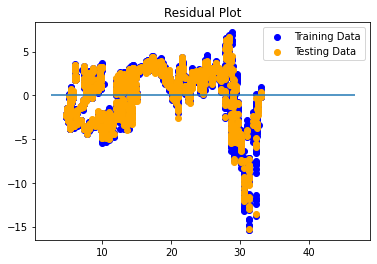

In [274]:
# Plot the Residuals for the Training and Testing data
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

In [275]:
# Linear Regression: X_test predictions to variable
predictions = model.predict(X_test)

#### R2 Score is a very popular metric used for evaluating the performance of linear regression models. Where R2 Score is between 0 and 1, the closer to 1, the better the regression fit.
#### Use MSE or MAE when comparing two or more models, the lower the value of MSE or MAE, the better. MSE (Mean Square Error): Uses Euclidean distance to calculate the error. MSE gives the magnitude of the error only.

In [276]:
# Used X_test, y_test, and model.predict(X_test) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 9.265629785123304, R2: 0.8763648057427191


#### Lasso regression imposes a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero. It comes with a parameter, alpha , and the higher the alpha , the more feature coefficients are zero. When alpha is 0 , Lasso regression produces the same coefficients as a linear regression.

In [277]:
# LASSO model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 9.264036706889305, R2: 0.8763860628554567


In [278]:
# Ridge model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 9.26562936878569, R2: 0.876364811298087


In [279]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 9.264037554983648, R2: 0.8763860515389773


# Hyperparameter Tuning

In [280]:
y_target = df_mongo["Close"]
y_target.shape

(5974,)

In [281]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_target, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4480, 3) (4480,)
(1494, 3) (1494,)


In [282]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4480, 3) (4480,)
(1494, 3) (1494,)


#### GridSearchCV and RandomizedSearchCV are techniques to evaluate models for a given hyperparameter vector using cross-validation, hence the “CV” suffix of the class name.
#### We are executing many models together is to find which machine learning model works best for this particular dataset.

In [283]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [284]:
regressors = [
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [285]:
from time import time
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

RandomForestRegressor()
	Training time: 0.494s
	Prediction time: 0.032s
	Explained variance: 0.993257264950107
	Mean absolute error: 0.4554628493756292
	R2 score: 0.9932572513489096

DecisionTreeRegressor()
	Training time: 0.005s
	Prediction time: 0.001s
	Explained variance: 0.9932654200090121
	Mean absolute error: 0.45547117914676327
	R2 score: 0.9932653816029412

KNeighborsRegressor()
	Training time: 0.005s
	Prediction time: 0.020s
	Explained variance: 0.9911540133092306
	Mean absolute error: 0.5054985237991025
	R2 score: 0.9911247950438905

GradientBoostingRegressor()
	Training time: 0.237s
	Prediction time: 0.005s
	Explained variance: 0.9910047646685992
	Mean absolute error: 0.5602471370627538
	R2 score: 0.9910045038190319

KNeighborsRegressor()
	Training time: 0.005s
	Prediction time: 0.008s
	Explained variance: 0.9911540133092306
	Mean absolute error: 0.5054985237991025
	R2 score: 0.9911247950438905

ExtraTreesRegressor()
	Training time: 0.368s
	Prediction time: 0.037s
	Explained

#### By comparing these results, we can quickly see that RandomForestRegressor and DecisionTreeRegressor are the best models for our data
#### Machine learning models have parameters, which are the internal coefficients set by training or optimizing the model on a training dataset.
#### Parameters are different from hyperparameters. Parameters are learned automatically; hyperparameters are set manually to help guide the learning process.

In [286]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [287]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [288]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [289]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [290]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.4566 degrees.
Accuracy = 96.92%.
Model Performance
Average Error: 0.4549 degrees.
Accuracy = 96.92%.
Improvement of 0.01%.


In [291]:
base_accuracy

96.91563020719917

In [292]:
# Hyperparameter tuning has not improved accuracy significantly

In [293]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, y_train)
y_test_pred = model_rfr.predict(X_test)
y_test_pred

array([23.23561114, 14.7653362 , 10.67808103, ...,  5.81904921,
       13.36797866,  4.21487043])

In [294]:
#RandomForestRegressor Residual showing difference actual vs predicted
residual_dtr = pd.DataFrame([model_rfr.predict(X_train),y_train,(model_rfr.predict(X_train)-y_train)])
residual_dtr.tail

<bound method NDFrame.tail of         0        1          2          3          4         5          6     \
0  11.234255  4.21487  17.049593  13.353855  14.248987  8.156072  22.166671   
1  10.950000  4.15000  16.809999  13.830000  13.910000  7.810000  22.780001   
2   0.284255  0.06487   0.239594  -0.476145   0.338987  0.346072  -0.613330   

       7          8          9     ...       4470      4471       4472  \
0  4.691541  20.189922  10.935276  ...  20.374694  4.691541  23.019013   
1  4.120000  19.500000  10.800000  ...  19.740000  4.300000  21.389999   
2  0.571541   0.689922   0.135276  ...   0.634694  0.391541   1.629014   

        4473       4474      4475       4476       4477      4478       4479  
0  11.234255  14.155334  5.283789  27.250945  17.632469  6.537091  25.721346  
1  10.050000  14.340000  4.550000  27.240000  16.860001  6.400000  26.340000  
2   1.184255  -0.184666  0.733789   0.010945   0.772468  0.137091  -0.618654  

[3 rows x 4480 columns]>

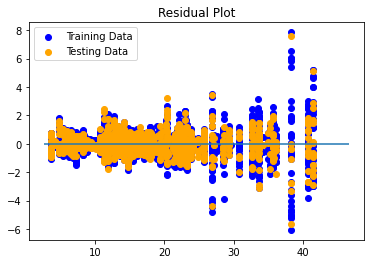

In [295]:
# Make predictions using fitted model
predictions1 = model_rfr.predict(X_test)

# Plotted the difference between the model predicted values and actual y values, versus the model predicted values
plt.scatter(model_rfr.predict(X_train), y_train - model_rfr.predict(X_train), c="blue", label="Training Data")
plt.scatter(model_rfr.predict(X_test), y_test - model_rfr.predict(X_test), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

# Save the Model

In [296]:
import pickle
filename = '../../static/shl_model_rfr.sav'
pickle.dump(model, open(filename, 'wb'))
model_in_rfr = pickle.load(open(filename, 'rb'))

In [297]:
# from joblib import dump,load
# model_in_rfr = load('shl_model_rfr.sav')

In [298]:
rba = float(1.35)
fed = float(1.75)
cpi = float(123.90)
input =40
rfr=[]

def randomforest(rba,fed,cpi):
    for i in range(0,input):
      rfr.append([rba,fed,cpi])
      np.round_(rfr,2,out = None) 
      df = pd.DataFrame(rfr, columns = ['RBA','FED',"CPI"])
      df.round(2)
      pred_rf=model_in_rfr.predict(df)
      df['Prediction'] = pred_rf
      df['Prediction'] = df['Prediction'].astype(float).round(2)
      rba+=0.25
      fed+=0.25
      cpi+=0.25
      # print(df)
    my_rforest = df.to_dict(orient='records')
    for dict_value in my_rforest:
      for k, v in dict_value.items():
        dict_value[k] = round(v, 2)
    return my_rforest,df
# print(my_rforest)
my_rf,df = randomforest(rba,fed,cpi)
print(df,my_rf)


      RBA    FED     CPI  Prediction
0    1.35   1.75  123.90       32.02
1    1.60   2.00  124.15       32.28
2    1.85   2.25  124.40       32.54
3    2.10   2.50  124.65       32.80
4    2.35   2.75  124.90       33.06
5    2.60   3.00  125.15       33.32
6    2.85   3.25  125.40       33.58
7    3.10   3.50  125.65       33.84
8    3.35   3.75  125.90       34.10
9    3.60   4.00  126.15       34.36
10   3.85   4.25  126.40       34.62
11   4.10   4.50  126.65       34.88
12   4.35   4.75  126.90       35.14
13   4.60   5.00  127.15       35.40
14   4.85   5.25  127.40       35.66
15   5.10   5.50  127.65       35.92
16   5.35   5.75  127.90       36.18
17   5.60   6.00  128.15       36.44
18   5.85   6.25  128.40       36.70
19   6.10   6.50  128.65       36.96
20   6.35   6.75  128.90       37.22
21   6.60   7.00  129.15       37.48
22   6.85   7.25  129.40       37.74
23   7.10   7.50  129.65       38.01
24   7.35   7.75  129.90       38.27
25   7.60   8.00  130.15       38.53
2

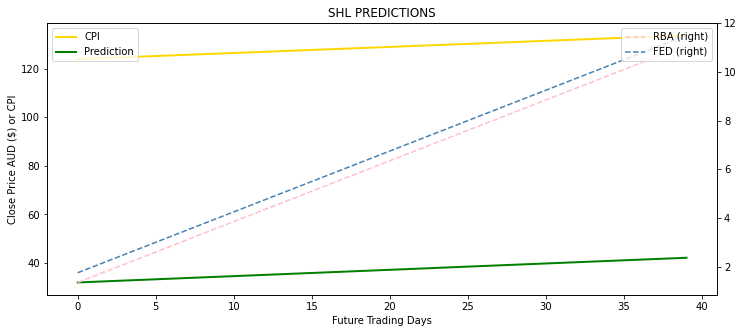

In [299]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
input=40
# df_pred = df.iloc[0:(input-1)]
plot1 = df.plot(y=["CPI","Prediction"], figsize=(12, 5),color=['gold','green'],linewidth=2)
plot2 = df.plot(y=["RBA","FED"],secondary_y=True, ax=plot1,color=['pink','steelblue'],linestyle='dashed')
plt.title('SHL PREDICTIONS')
plot1.set_xlabel('Future Trading Days', fontsize=10)
plot1.set_ylabel('Close Price AUD ($) or CPI', fontsize=10)
plot1.legend(loc='upper left')
plot2.legend(loc='upper right')
plt.savefig('../../static/data/images/shl_rfr_pred.png', bbox_inches="tight")
plt.show()

In [300]:
rba = float(1.35)
fed = float(1.75)
cpi = float(123.90)
def rforest(rba,fed,cpi):
    dtr =[[rba,fed,cpi]]
    df = pd.DataFrame (dtr, columns = ['RBA','FED',"CPI"])
    pred_dtr=model_in_rfr.predict(df)
    df['Prediction'] = pred_dtr
    print(df)
    df_dict = df.to_dict(orient='records')
    return pred_dtr
Pred_rf = rforest(rba,fed,cpi)
print(Pred_rf)

    RBA   FED    CPI  Prediction
0  1.35  1.75  123.9   32.015478
[32.01547842]


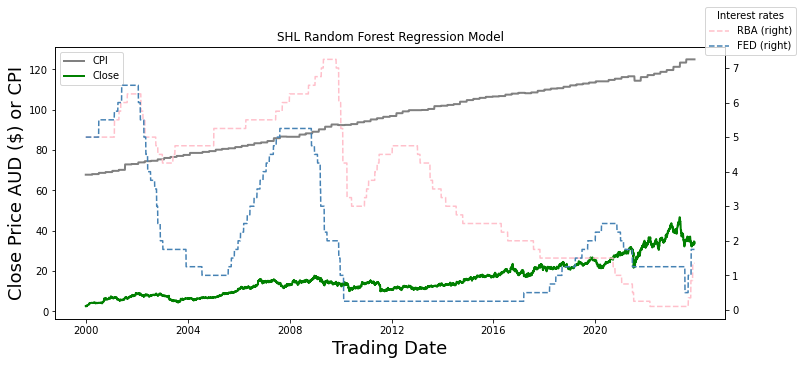

In [301]:
x = np.arange(2000,2024,4)
ax = df_mongo.plot(y=["CPI","Close"], figsize=(12, 5),color=['grey','green'],linewidth=2)
df_mongo.plot(y=["RBA","FED"],secondary_y=True, ax=ax,color=['pink','steelblue'],linestyle='dashed')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=-4, title="Interest rates")
ax.legend(loc='upper left')
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax.set_xticklabels(x, rotation=0)
ax.set_title('SHL Random Forest Regression Model')
ax.set_xlabel('Trading Date', fontsize=18)
ax.set_ylabel('Close Price AUD ($) or CPI', fontsize=18)
plt.savefig('../../static/data/images/shl_tree.png')

#Save predicted error to MongoDB

In [302]:
# Module used to connect Python with MongoDb
import pymongo

In [303]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

name = 'SHL'

In [304]:
# query the classroom collection
companys = db.find({
      'model': 'RFR',
      'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62ea37a78b4c3f84ed6807a4'), 'model': 'RFR', 'name': 'SHL', 'date': '29/07/2022', 'predicted': 32, 'actual': 34, 'difference': -1.9845, 'accuracy': 96.92}


In [305]:
#save last price actual to variable
actual_price = df_mongo.iloc[-1,5]
actual_date = df_mongo.iloc[-1,1] 
actual_price = int(actual_price)
base_accuracy=round(base_accuracy,2)
print(base_accuracy,actual_price,actual_date)


96.92 34 29/07/2022


In [306]:
# Set keys and values of company
predicted = int(Pred_rf)
difference = Pred_rf-actual_price
difference=difference[0]
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference},accuracy {base_accuracy}')

date 29/07/2022,predicted 32,actual 34, difference -1.9845215812565442,accuracy 96.92


In [307]:
# Delete a document from a collection
db.delete_one(
    {'model': 'RFR','name': name}
)


In [308]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'RFR',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'difference': round(difference,4),
      'accuracy': base_accuracy        
    }
)

# query the classroom collection
companys = db.find({
  'model': 'RFR',
  'name': name,})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62ea3af48b4c3f84ed6807a7'), 'model': 'RFR', 'name': 'SHL', 'date': '29/07/2022', 'predicted': 32, 'actual': 34, 'difference': -1.9845, 'accuracy': 96.92}
